In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
#TRENING W COLAB
# ---------------------------------------------------------
# 1. IMPORTY I KONFIGURACJA ŚRODOWISKA
# ---------------------------------------------------------
!pip install pyDOE --quiet

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
from tqdm.auto import tqdm
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używane urządzenie: {device}")

# Ziarno losowości dla powtarzalności
torch.manual_seed(1234)
np.random.seed(1234)

# ---------------------------------------------------------
# 2. FDM - ROZWIĄZANIE REFERENCYJNE (GROUND TRUTH)
# ---------------------------------------------------------
def compute_fdm(x_max, t_max, nx, nt, nu):
    """Oblicza rozwiązanie numeryczne metodą różnic skończonych."""
    dx = x_max / (nx - 1)
    dt = t_max / nt
    x = np.linspace(0, x_max, nx)
    u = np.sin(np.pi * x)
    u_res = np.zeros((nx, nt))
    u_res[:, 0] = u

    u_curr = u.copy()
    factor = dt / dx
    factor2 = (nu * dt) / (dx**2)

    for n in range(0, nt - 1):
        u_next = u_curr.copy()
        u_next[1:-1] = (u_curr[1:-1] 
                        - u_curr[1:-1] * factor * (u_curr[1:-1] - u_curr[0:-2]) 
                        + factor2 * (u_curr[2:] - 2*u_curr[1:-1] + u_curr[0:-2]))
        u_next[0] = 0
        u_next[-1] = 0
        u_res[:, n+1] = u_next
        u_curr = u_next
        
    return x, np.linspace(0, t_max, nt), u_res

# ---------------------------------------------------------
# 3. MODEL PINN
# ---------------------------------------------------------
class PhysicsInformedNN(nn.Module):
    def __init__(self, layers, viscosity):
        super().__init__()
        self.viscosity = viscosity
        self.activation = nn.Tanh()
        self.linears = nn.ModuleList()
        
        # Dynamiczne tworzenie warstw na podstawie listy
        for i in range(len(layers) - 1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
            
        # Inicjalizacja Xavier
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        x = x.float().to(device)
        
        a = x
        for i in range(len(self.linears) - 1):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a

    def compute_pde_residual(self, x_pde):
        x_pde = x_pde.clone()
        x_pde.requires_grad = True
        u = self.forward(x_pde)
        
        u_xt = torch.autograd.grad(u, x_pde, torch.ones_like(u), create_graph=True)[0]
        u_x = u_xt[:, 0:1]
        u_t = u_xt[:, 1:2]
        u_xx = torch.autograd.grad(u_x, x_pde, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
        
        # Równanie Burgersa
        f = u_t + u * u_x - self.viscosity * u_xx
        return f

# ---------------------------------------------------------
# 4. FUNKCJA EKSPERYMENTALNA
# ---------------------------------------------------------
def run_experiment(config_name, config, fdm_data):
    print(f"\n--- Uruchamianie eksperymentu: {config_name} ---")
    
    # Rozpakowanie konfiguracji
    x_range = config['x_range'] # [0, 2]
    t_range_train = config['t_range_train'] # np. [0, 1.0] - PINN może uczyć się dłużej niż FDM
    nu = config['viscosity']
    
    # Dane FDM (do porównania w zakresie t < 0.48)
    x_fdm, t_fdm, u_fdm = fdm_data
    
    # 1. Przygotowanie danych treningowych (Losowanie)
    # IC (t=0)
    x_col = np.linspace(x_range[0], x_range[1], 1000)[:, None]
    t_col = np.zeros_like(x_col)
    u_col = np.sin(np.pi * x_col)
    
    idx_ic = np.random.choice(x_col.shape[0], config['N_ic'], replace=False)
    X_ic = torch.tensor(np.hstack((x_col[idx_ic], t_col[idx_ic])), dtype=torch.float32).to(device)
    U_ic = torch.tensor(u_col[idx_ic], dtype=torch.float32).to(device)

    # BC (x=0 i x=2)
    t_col_bc = np.linspace(t_range_train[0], t_range_train[1], 1000)[:, None]
    x_bc_left = np.zeros_like(t_col_bc) + x_range[0]
    x_bc_right = np.zeros_like(t_col_bc) + x_range[1]
    
    X_bc_all = np.vstack([
        np.hstack((x_bc_left, t_col_bc)),
        np.hstack((x_bc_right, t_col_bc))
    ])
    U_bc_all = np.zeros((X_bc_all.shape[0], 1))
    
    idx_bc = np.random.choice(X_bc_all.shape[0], config['N_bc'], replace=False)
    X_bc = torch.tensor(X_bc_all[idx_bc], dtype=torch.float32).to(device)
    U_bc = torch.tensor(U_bc_all[idx_bc], dtype=torch.float32).to(device)

    # PDE (LHS wewnątrz)
    lb = np.array([x_range[0], t_range_train[0]])
    ub = np.array([x_range[1], t_range_train[1]])
    X_pde = lb + (ub - lb) * lhs(2, config['N_pde'])
    X_pde = torch.tensor(X_pde, dtype=torch.float32).to(device)
    
    # Punkty do residuum obejmują też brzegi
    X_pde_all = torch.vstack((X_pde, X_ic, X_bc))

    # 2. Inicjalizacja modelu
    model = PhysicsInformedNN(config['layers'], nu).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    
    # Wagi funkcji straty
    w_data = config['loss_weights']['data']
    w_pde = config['loss_weights']['pde']

    # 3. Pętla treningowa
    loss_history = []
    
    pbar = tqdm(range(config['epochs']), desc=f"Trenowanie {config_name}")
    for i in pbar:
        optimizer.zero_grad()
        
        # Loss danych (IC + BC)
        u_pred_ic = model(X_ic)
        u_pred_bc = model(X_bc)
        loss_data = torch.mean((u_pred_ic - U_ic)**2) + torch.mean((u_pred_bc - U_bc)**2)
        
        # Loss fizyki (PDE)
        f_pred = model.compute_pde_residual(X_pde_all)
        loss_pde = torch.mean(f_pred**2)
        
        # Ważona suma
        loss = w_data * loss_data + w_pde * loss_pde
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            loss_history.append(loss.item())
            pbar.set_description(f"Loss: {loss.item():.6f} (Data: {loss_data.item():.6f}, PDE: {loss_pde.item():.6f})")

    # 4. Ewaluacja na pełnej siatce (dla wizualizacji t=0 do t=1.0)
    # Tworzymy gęstą siatkę do wizualizacji
    nx_eval, nt_eval = 200, 200
    x_eval = np.linspace(x_range[0], x_range[1], nx_eval)
    t_eval = np.linspace(t_range_train[0], t_range_train[1], nt_eval)
    X_eval, T_eval = np.meshgrid(x_eval, t_eval) # shape [nt, nx]
    
    X_flat = X_eval.flatten()[:, None]
    T_flat = T_eval.flatten()[:, None]
    input_eval = np.hstack((X_flat, T_flat))
    
    model.eval()
    with torch.no_grad():
        u_pred_flat = model(input_eval).cpu().numpy()
    
    u_pred_grid = u_pred_flat.reshape(nt_eval, nx_eval)

    # Obliczenie błędu względem FDM (tylko w zakresie gdzie FDM istnieje, t <= 0.48)
    # Musimy zinterpolować lub wybrać punkty pasujące do FDM. 
    # Dla uproszczenia weźmiemy ostatni punkt FDM (t=0.48) i sprawdzimy predykcję modelu w tym czasie.
    
    # Sprawdzenie dla t = 0.48
    t_check = 0.48
    x_check = torch.tensor(x_fdm, dtype=torch.float32).view(-1, 1)
    t_check_vec = torch.ones_like(x_check) * t_check
    input_check = torch.hstack((x_check, t_check_vec)).to(device)
    
    with torch.no_grad():
        u_at_048 = model(input_check).cpu().numpy().flatten()
    
    # U_FDM w ostatnim kroku czasowym (odpowiadającym t=0.48)
    u_fdm_048 = u_fdm[:, -1] 
    rmse_048 = np.sqrt(np.mean((u_at_048 - u_fdm_048)**2))
    
    results = {
        'name': config_name,
        'model_state': model.state_dict(),
        'loss_history': loss_history,
        'rmse_048': rmse_048,
        'u_pred_grid': u_pred_grid, # Pełna predykcja (macierz)
        'grid_extent': [x_range[0], x_range[1], t_range_train[0], t_range_train[1]],
        'u_at_048': u_at_048,
        'x_vec': x_fdm
    }
    
    return results

# ---------------------------------------------------------
# 5. KONFIGURACJA WARIANTÓW
# ---------------------------------------------------------

# Stałe parametry fizyczne
VISCOSITY = 0.01 / np.pi
X_RANGE = [0, 2]

# Obliczamy FDM raz (jako odniesienie)
nx_fdm = 1001
nt_fdm = 1000
t_max_fdm = 0.48
fdm_data = compute_fdm(X_RANGE[1], t_max_fdm, nx_fdm, nt_fdm, VISCOSITY)

# Definicja wariantów eksperymentu
variants = {
    'Bazowy': {
        'layers': [2, 32, 128, 128, 128, 32, 1],
        'N_ic': 1000, 'N_bc': 1000, 'N_pde': 2000,
        'epochs': 100000, 'lr': 0.001,   
        'viscosity': VISCOSITY, 'x_range': X_RANGE,
        't_range_train': [0, 1.0], # Uczymy do t=1.0, żeby zobaczyć szok
        'loss_weights': {'data': 1.0, 'pde': 1.0}
    },
    'Mala_Siec': {
        'layers': [2, 10, 10, 1], # Bardzo mała sieć
        'N_ic': 1000, 'N_bc': 1000, 'N_pde': 2000,
        'epochs': 100000, 'lr': 0.001,   
        'viscosity': VISCOSITY, 'x_range': X_RANGE,
        't_range_train': [0, 1.0],
        'loss_weights': {'data': 1.0, 'pde': 1.0}
    },
    'Malo_Punktow': {
        'layers': [2, 32, 128, 128, 128, 32, 1],
        'N_ic': 50, 'N_bc': 50, 'N_pde': 200, # Drastycznie mniej punktów
        'epochs': 100000, 'lr': 0.001,
        'viscosity': VISCOSITY, 'x_range': X_RANGE,
        't_range_train': [0, 1.0],
        'loss_weights': {'data': 1.0, 'pde': 1.0}
    },
    'Waga_Fizyka_x10': {
        'layers': [2, 32, 128, 128, 128, 32, 1],
        'N_ic': 1000, 'N_bc': 1000, 'N_pde': 2000,
        'epochs': 100000, 'lr': 0.001,
        'viscosity': VISCOSITY, 'x_range': X_RANGE,
        't_range_train': [0, 1.0],
        'loss_weights': {'data': 1.0, 'pde': 10.0} # Mocniejszy nacisk na równanie
    }
}

# # ---------------------------------------------------------
# # 6. URUCHOMIENIE I ZAPIS
# # ---------------------------------------------------------
# SAVE_RESULTS_TO_FILE = True # Zmień na True, aby zapisać plik

# all_results = {}

# for name, config in variants.items():
#     res = run_experiment(name, config, fdm_data)
#     all_results[name] = res

#     # Szybki podgląd wyników
#     print(f"RMSE dla {name} w t=0.48: {res['rmse_048']:.5f}")

# # Zapisywanie do pliku (opcjonalne)
# if SAVE_RESULTS_TO_FILE:
#     import pickle
#     filename = "pinn_variants_results.pkl"
#     # Usuwamy tensory GPU przed zapisem pickle, żeby nie było błędów przy wczytywaniu na CPU
#     # (w tym kodzie res już zawiera numpy arrays, więc jest bezpiecznie)
#     with open(filename, 'wb') as f:
#         pickle.dump(all_results, f)
#     print(f"\nZapisano wszystkie wyniki do pliku: {filename}")


# # ---------------------------------------------------------
# # 7. PORÓWNANIE GRAFICZNE
# # ---------------------------------------------------------
# # Wykres 1: Porównanie w t=0.48 (gdzie mamy FDM)
# plt.figure(figsize=(12, 6))
# x_ref = fdm_data[0]
# u_ref = fdm_data[2][:, -1] # t=0.48
# plt.plot(x_ref, u_ref, 'k-', linewidth=2, label='FDM (Reference)')

# for name, res in all_results.items():
#     plt.plot(res['x_vec'], res['u_at_048'], '--', label=f"{name} (RMSE: {res['rmse_048']:.4f})")

# plt.title("Porównanie rozwiązań w t=0.48 (Moment przed szokiem)")
# plt.xlabel("x")
# plt.ylabel("u(x, t=0.48)")
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()

# # Wykres 2: Mapy ciepła dla wariantu Bazowego (do t=1.0)
# res_base = all_results['Bazowy']
# extent = res_base['grid_extent'] # [x_min, x_max, t_min, t_max]
# # Uwaga: imshow wymaga [t_min, t_max, x_min, x_max] jeśli oś X to czas, 
# # ale tutaj w u_pred_grid (shape [nt, nx]) wiersze to czas, kolumny to x.
# # origin='lower' ustawi t=0 na dole.

# plt.figure(figsize=(10, 5))
# plt.imshow(res_base['u_pred_grid'], interpolation='nearest', cmap='rainbow', 
#            extent=[extent[0], extent[1], extent[2], extent[3]], 
#            origin='lower', aspect='auto')
# plt.colorbar(label='u(x,t)')
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title(f"Rozwiązanie PINN (Wariant: Bazowy) do t=1.0\nZauważ formowanie się fali uderzeniowej przy t>0.5")
# plt.show()

In [14]:
# ---------------------------------------------------------
# 1. FUNKCJE POMOCNICZE (FDM i MSE)
# ---------------------------------------------------------
def compute_fdm_1d(x_vec, t, nu):
    """
    Oblicza rozwiązanie FDM dla jednego kroku czasowego t,
    startując od t=0 (warunek początkowy).
    Służy jako Ground Truth do obliczenia błędów.
    """
    dt = 0.00048 # Mały krok czasowy dla stabilności FDM
    dx = x_vec[1] - x_vec[0]
    nt = int(t / dt)
    
    u = np.sin(np.pi * x_vec) # Warunek początkowy t=0
    
    factor = dt / dx
    factor2 = (nu * dt) / (dx**2)
    
    for _ in range(nt):
        u_next = u.copy()
        u_next[1:-1] = (u[1:-1] 
                        - u[1:-1] * factor * (u[1:-1] - u[0:-2]) 
                        + factor2 * (u[2:] - 2*u[1:-1] + u[0:-2]))
        u_next[0] = 0
        u_next[-1] = 0
        u = u_next
        
    return u

def calculate_mse(u_pred, u_true):
    return np.mean((u_pred - u_true)**2)


In [15]:
# ---------------------------------------------------------
# 2. ŁADOWANIE DANYCH
# ---------------------------------------------------------
filename = "pinn_variants_results_1.pkl"
VISCOSITY = 0.01 / np.pi

try:
    with open(filename, "rb") as f:
        all_results = pickle.load(f)
    print(f"Wczytano wyniki dla wariantów: {list(all_results.keys())}")
except FileNotFoundError:
    print(f"Błąd: Nie znaleziono pliku {filename}. Upewnij się, że został wygenerowany i zapisany.")
    # Tworzymy atrapy danych, aby kod się wykonał w przykładzie (usuń to w prawdziwym użyciu)
    all_results = {}


Wczytano wyniki dla wariantów: ['Bazowy', 'Mala_Siec', 'Malo_Punktow', 'Waga_Fizyka_x10']


In [16]:
# ---------------------------------------------------------
# 3. KONFIGURACJA WIZUALIZACJI
# ---------------------------------------------------------
# Wybrane momenty czasowe do analizy
time_steps = [0.0, 0.25, 0.48, 0.50, 0.52]

# Style linii dla różnych wariantów (dla czytelności)
styles = ['-', '--', '-.', ':']
colors = ['blue', 'green', 'orange', 'purple', 'brown']



--- Analiza dla czasu t = 0.0 ---


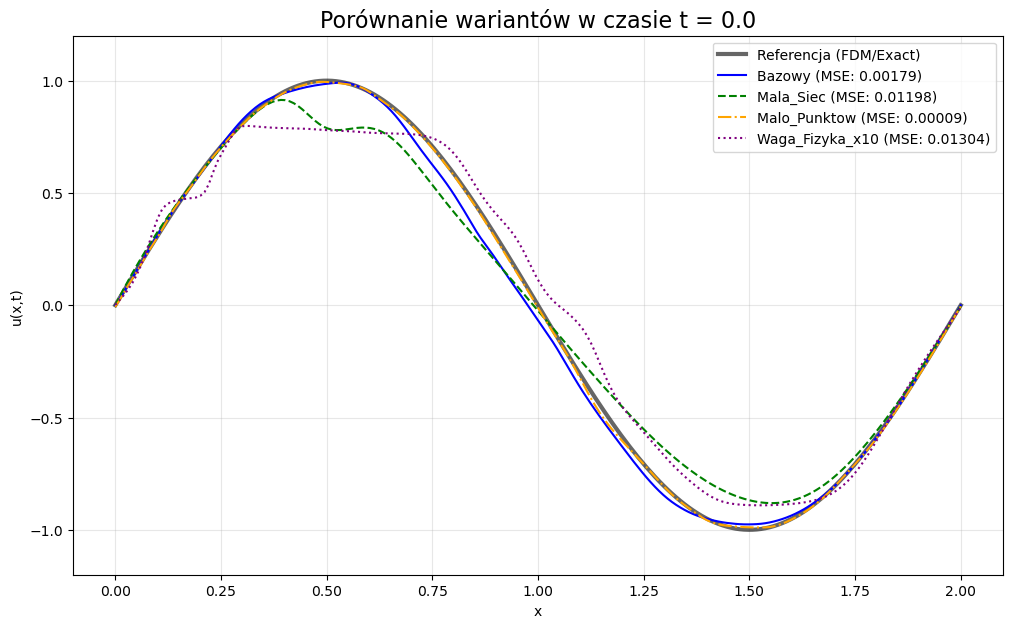

Ranking błędów (MSE) dla t=0.0:
  1. Malo_Punktow: 0.000086
  2. Bazowy: 0.001790
  3. Mala_Siec: 0.011983
  4. Waga_Fizyka_x10: 0.013037

--- Analiza dla czasu t = 0.25 ---


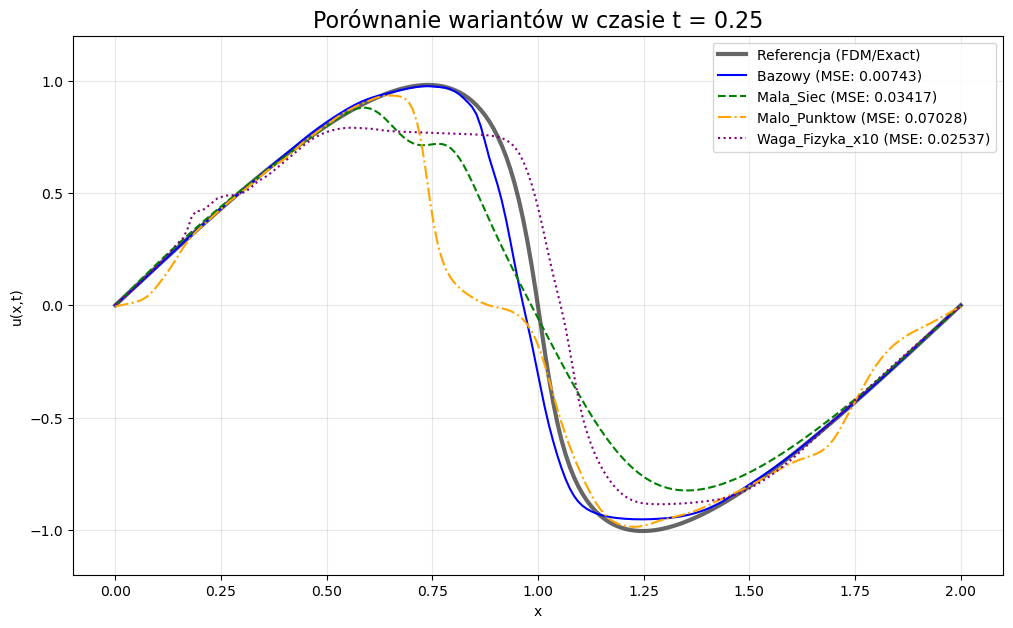

Ranking błędów (MSE) dla t=0.25:
  1. Bazowy: 0.007431
  2. Waga_Fizyka_x10: 0.025373
  3. Mala_Siec: 0.034168
  4. Malo_Punktow: 0.070281

--- Analiza dla czasu t = 0.48 ---


C:\Users\ja\AppData\Local\Temp\ipykernel_21180\3160539292.py:22: RuntimeWarning: overflow encountered in multiply
  - u[1:-1] * factor * (u[1:-1] - u[0:-2])
C:\Users\ja\AppData\Local\Temp\ipykernel_21180\3160539292.py:22: RuntimeWarning: invalid value encountered in subtract
  - u[1:-1] * factor * (u[1:-1] - u[0:-2])
C:\Users\ja\AppData\Local\Temp\ipykernel_21180\3160539292.py:21: RuntimeWarning: invalid value encountered in subtract
  u_next[1:-1] = (u[1:-1]
C:\Users\ja\AppData\Local\Temp\ipykernel_21180\3160539292.py:23: RuntimeWarning: invalid value encountered in subtract
  + factor2 * (u[2:] - 2*u[1:-1] + u[0:-2]))
C:\Users\ja\AppData\Local\Temp\ipykernel_21180\3160539292.py:23: RuntimeWarning: invalid value encountered in add
  + factor2 * (u[2:] - 2*u[1:-1] + u[0:-2]))
C:\Users\ja\AppData\Local\Temp\ipykernel_21180\3160539292.py:21: RuntimeWarning: invalid value encountered in add
  u_next[1:-1] = (u[1:-1]


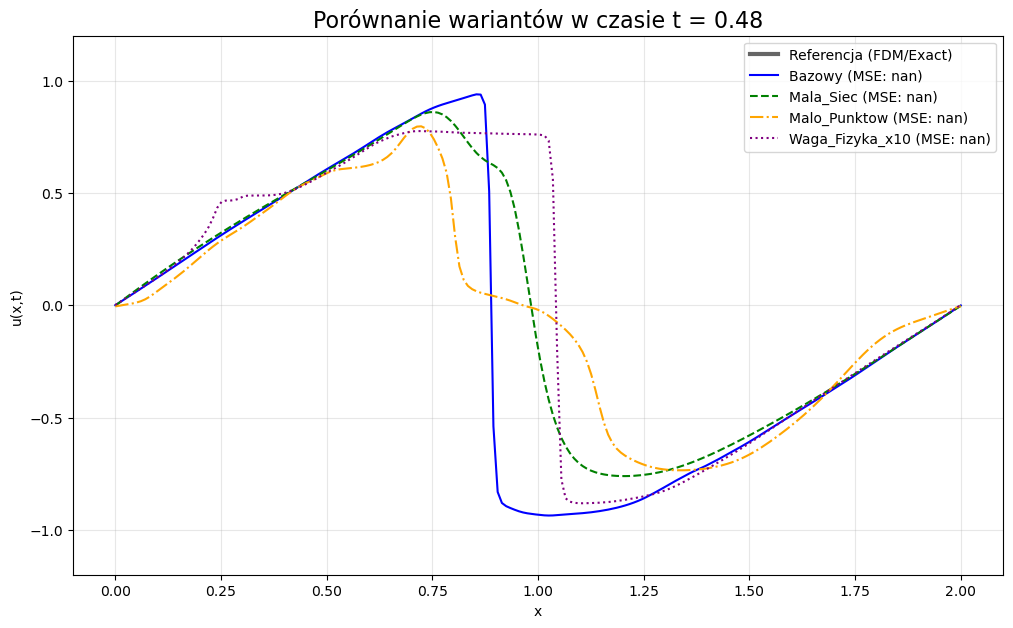

Ranking błędów (MSE) dla t=0.48:
  1. Bazowy: nan
  2. Mala_Siec: nan
  3. Malo_Punktow: nan
  4. Waga_Fizyka_x10: nan

--- Analiza dla czasu t = 0.5 ---


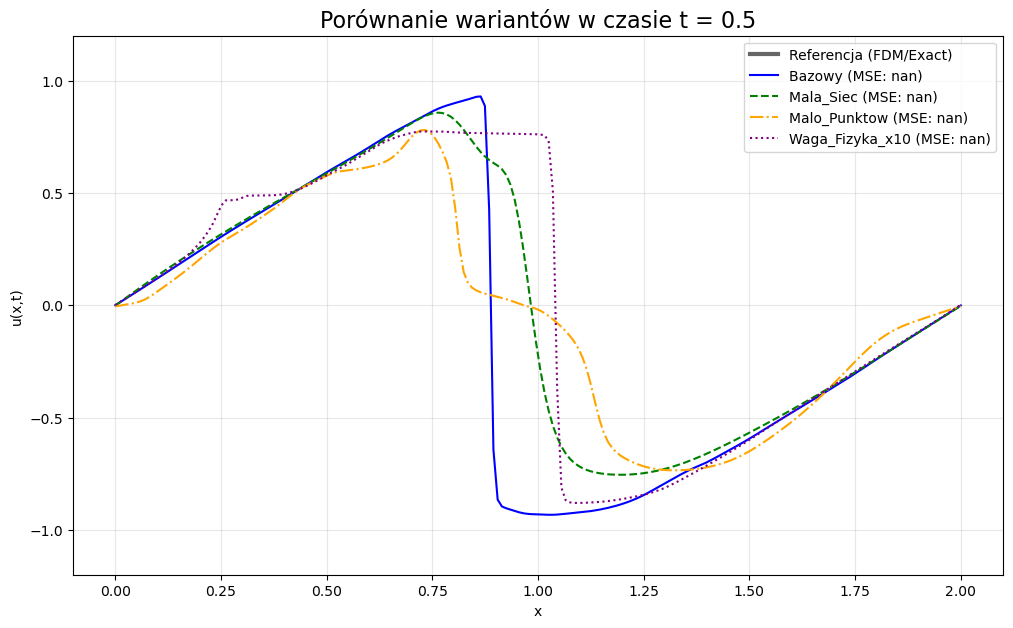

Ranking błędów (MSE) dla t=0.5:
  1. Bazowy: nan
  2. Mala_Siec: nan
  3. Malo_Punktow: nan
  4. Waga_Fizyka_x10: nan

--- Analiza dla czasu t = 0.52 ---


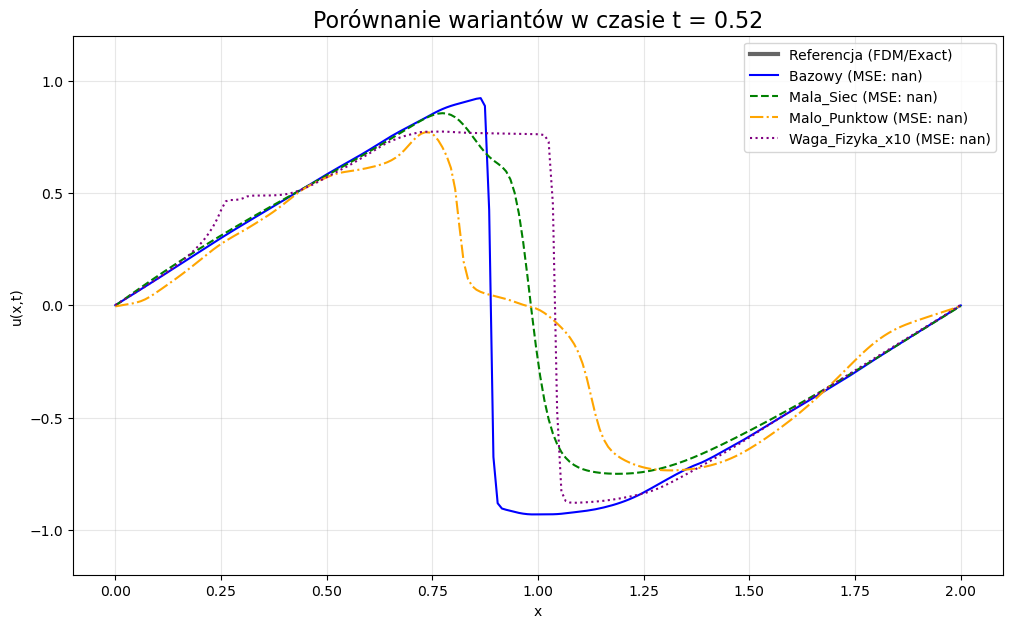

Ranking błędów (MSE) dla t=0.52:
  1. Bazowy: nan
  2. Mala_Siec: nan
  3. Malo_Punktow: nan
  4. Waga_Fizyka_x10: nan


In [17]:
# ---------------------------------------------------------
# 4. GENEROWANIE WYKRESÓW (JEDEN WYKRES NA KROK CZASOWY)
# ---------------------------------------------------------

if all_results:
    # Pobieramy wspólne parametry siatki z pierwszego wariantu (zakładamy, że są takie same)
    first_variant = next(iter(all_results.values()))
    extent = first_variant['grid_extent'] # [x_min, x_max, t_min, t_max]
    nx = first_variant['u_pred_grid'].shape[1]
    nt = first_variant['u_pred_grid'].shape[0]
    
    # Odtwarzamy wektory współrzędnych
    x_vec = np.linspace(extent[0], extent[1], nx)
    t_vec = np.linspace(extent[2], extent[3], nt)

    # Pętla po wybranych czasach
    for t_target in time_steps:
        print(f"\n--- Analiza dla czasu t = {t_target} ---")
        
        plt.figure(figsize=(12, 7))
        
        # 1. Oblicz i narysuj rozwiązanie referencyjne (FDM/Exact)
        # Znajdowanie najbliższego indeksu czasu w siatce
        idx_t = (np.abs(t_vec - t_target)).argmin()
        
        u_ref = compute_fdm_1d(x_vec, t_target, VISCOSITY)
        
        plt.plot(x_vec, u_ref, 'k-', linewidth=3, alpha=0.6, label='Referencja (FDM/Exact)')
        
        # 2. Iteracja po wszystkich wariantach sieci
        mse_scores = {}
        
        for i, (variant_name, data) in enumerate(all_results.items()):
            # Pobranie predykcji dla danego czasu
            # data['u_pred_grid'] ma kształt [czas, przestrzeń]
            u_pred = data['u_pred_grid'][idx_t, :]
            
            # Obliczenie błędu
            mse = calculate_mse(u_pred, u_ref)
            mse_scores[variant_name] = mse
            
            # Rysowanie
            style = styles[i % len(styles)]
            color = colors[i % len(colors)]
            
            plt.plot(x_vec, u_pred, linestyle=style, color=color, linewidth=1.5,
                     label=f"{variant_name} (MSE: {mse:.5f})")

        # Ustawienia wykresu
        plt.title(f"Porównanie wariantów w czasie t = {t_target}", fontsize=16)
        plt.xlabel("x")
        plt.ylabel("u(x,t)")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.ylim(-1.2, 1.2) # Stała skala dla łatwiejszego porównania
        plt.show()
        
        # Wypisanie rankingu dla danego czasu
        print(f"Ranking błędów (MSE) dla t={t_target}:")
        sorted_mse = sorted(mse_scores.items(), key=lambda item: item[1])
        for rank, (name, score) in enumerate(sorted_mse, 1):
            print(f"  {rank}. {name}: {score:.6f}")

else:
    print("Brak danych do przetworzenia.")